In [1]:
import skimage
import skimage.io as skio
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
im = skio.imread("imgs/castle.jpg")
# im = skimage.transform.rescale(im, scale=1/16, channel_axis=-1)

In [5]:
if im.max() > 1: # Normalize
    im = im/255.0

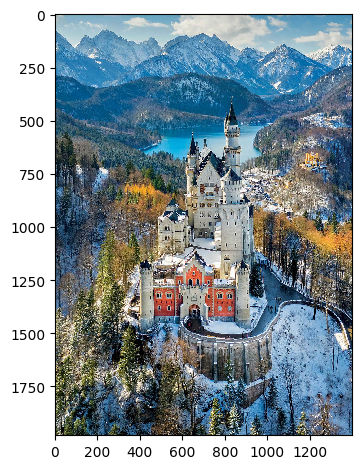

In [6]:
skio.imshow(im)

In [3]:
def positional_encoding(pos, L):
    PE = []
    for i in range(L):
        PE.append(np.sin((2**i)*np.pi*pos))
        PE.append(np.cos((2**i)*np.pi*pos))
    return np.stack([pos] + PE, axis=-1)

In [4]:
class NeuralField(nn.Module):
    def __init__(self, L=10):
        super().__init__()
        self.L=L

        self.model = nn.Sequential(
            nn.Linear(L*4 + 2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            nn.Linear(256, 3),
            nn.Sigmoid()
        )
    
    def forward(self, pos):
        pe = positional_encoding(pos, self.L)
        pe = torch.tensor(pe, device=device).float()
        pe = pe.reshape(pe.shape[0], -1)
        return self.model(pe)

In [5]:
class DataLoader:
    def __init__(self, img):
        self.img = img

    def sample(self, N):
        pos = np.random.randint([0, 0], high=self.img.shape[:2], size=(N,2))
        rgb = self.img[pos[:, 0], pos[:, 1]]
        
        return pos/self.img.shape[:2], rgb

In [10]:
model = NeuralField(L=20).to(device)
dataloader = DataLoader(im)

In [303]:
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
batch_size = 10000
mse = nn.MSELoss()
training_loss = []
training_imgs = [] # Taken every 200 epochs
full_image_loss = [] # Taken every 200 epochs

In [304]:
x = np.arange(im.shape[0])
y = np.arange(im.shape[1])
all_coords = np.meshgrid(x, y)
all_coords[0] = all_coords[0].flatten()
all_coords[1] = all_coords[1].flatten()
all_coords = np.array(all_coords).T

In [305]:
os.mkdir("outs/castle/")

FileExistsError: [Errno 17] File exists: 'outs/castle/'

In [299]:
for i, img in enumerate(training_imgs):
    skio.imsave(f"outs/castle/{i}.jpg", standardize_img(img))

  0%|                                                                                          | 0/3001 [00:00<?, ?it/s]

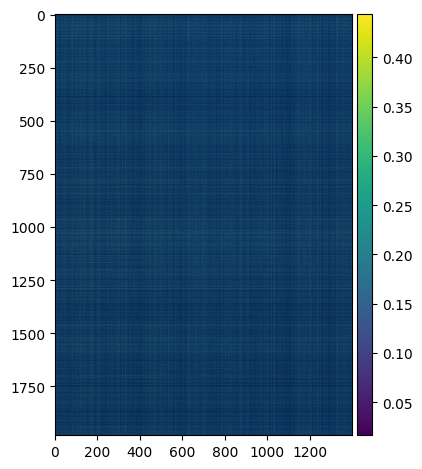

Epoch 199: training loss 2.1517395973205566:   7%|██▎                                | 196/3001 [00:10<01:03, 44.17it/s]

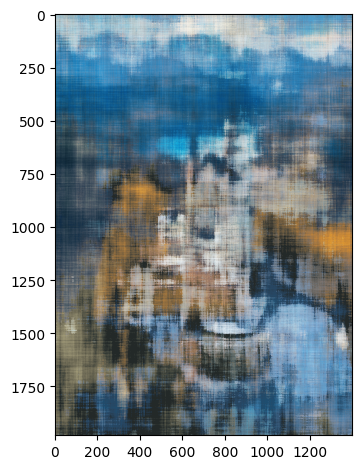

Epoch 399: training loss 2.0658810138702393:  13%|████▋                              | 400/3001 [00:20<01:01, 42.24it/s]

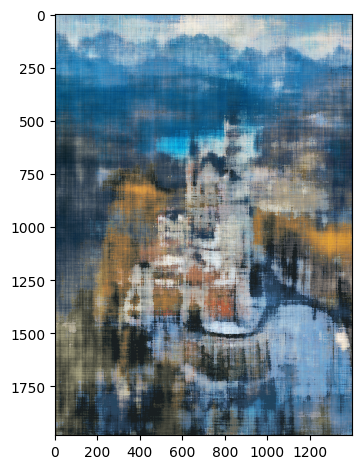

Epoch 599: training loss 1.8956104516983032:  20%|██████▉                            | 599/3001 [00:29<00:59, 40.71it/s]

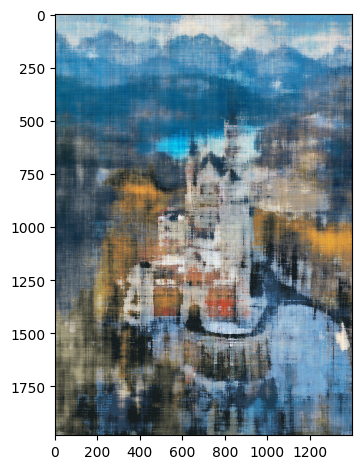

Epoch 799: training loss 1.8502334356307983:  27%|█████████▎                         | 799/3001 [00:39<00:55, 39.56it/s]

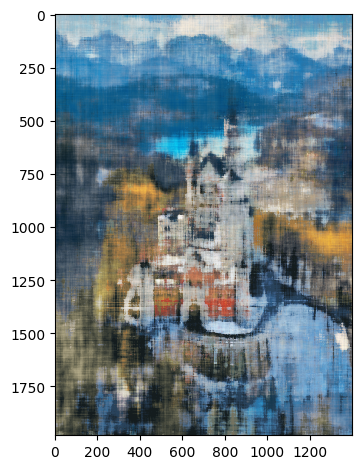

Epoch 999: training loss 1.7789855003356934:  33%|███████████▌                       | 996/3001 [00:48<00:47, 42.34it/s]

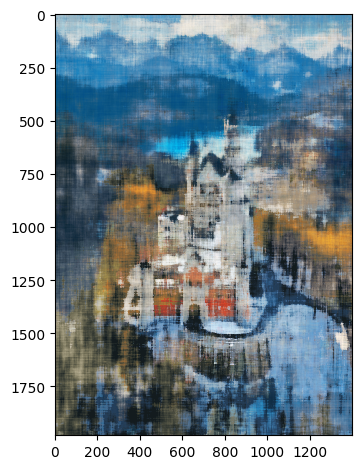

Epoch 1199: training loss 1.744827389717102:  40%|█████████████▌                    | 1196/3001 [00:58<00:42, 42.92it/s]

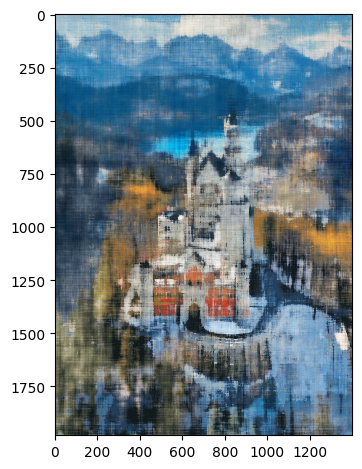

Epoch 1399: training loss 1.7361246347427368:  47%|███████████████▍                 | 1400/3001 [01:07<00:36, 43.37it/s]

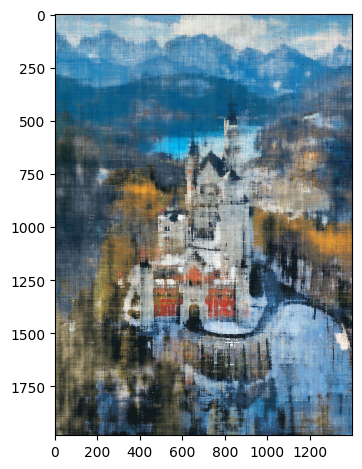

Epoch 1599: training loss 1.7183326482772827:  53%|█████████████████▌               | 1600/3001 [01:16<00:31, 43.99it/s]

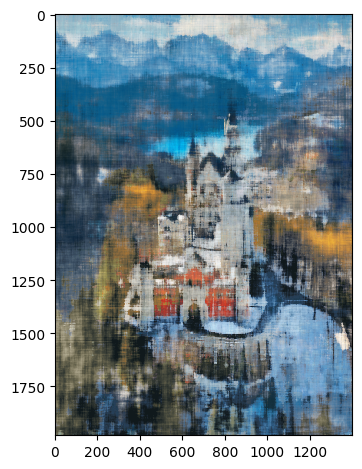

Epoch 1799: training loss 1.742911696434021:  60%|████████████████████▍             | 1800/3001 [01:26<00:27, 43.28it/s]

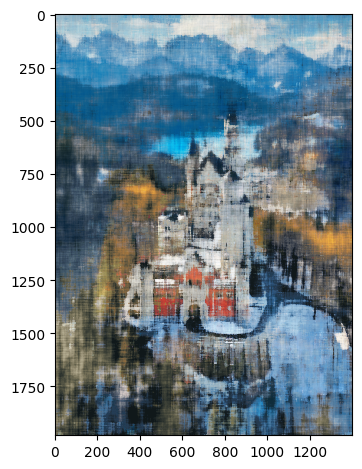

Epoch 1999: training loss 1.7180949449539185:  67%|█████████████████████▉           | 2000/3001 [01:36<00:23, 41.98it/s]

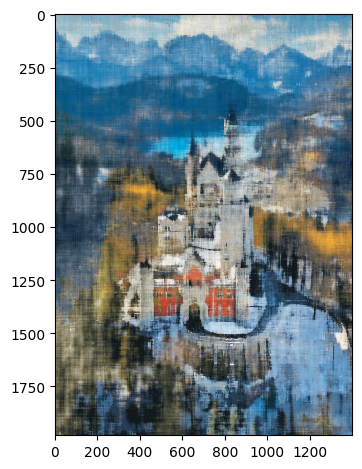

Epoch 2199: training loss 1.699941635131836:  73%|████████████████████████▉         | 2200/3001 [01:45<00:19, 41.47it/s]

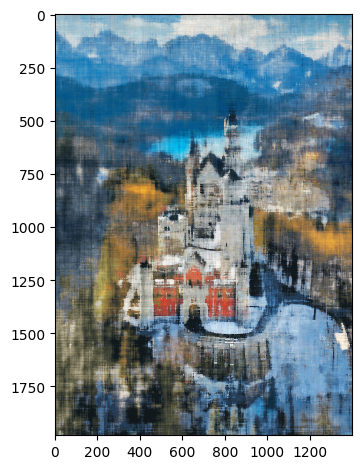

Epoch 2399: training loss 1.6640040874481201:  80%|██████████████████████████▍      | 2400/3001 [01:55<00:14, 42.38it/s]

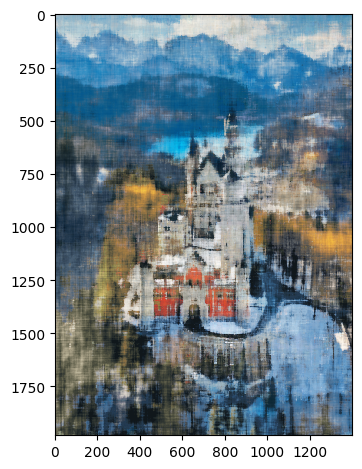

Epoch 2599: training loss 1.6282833814620972:  87%|████████████████████████████▌    | 2600/3001 [02:04<00:09, 44.22it/s]

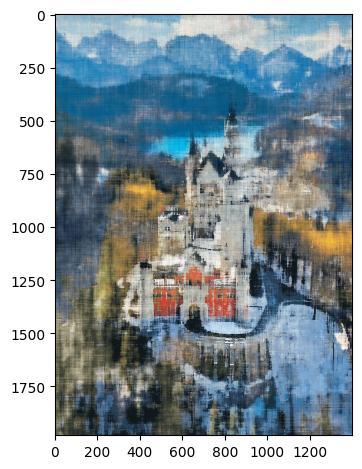

Epoch 2799: training loss 1.6442937850952148:  93%|██████████████████████████████▊  | 2800/3001 [02:13<00:04, 43.59it/s]

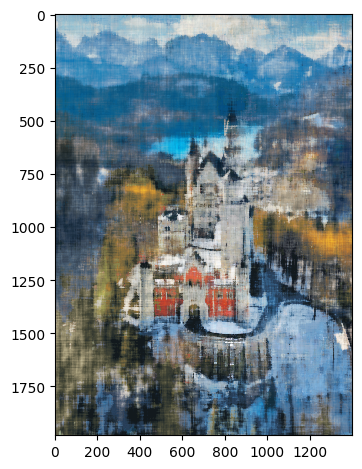

Epoch 2999: training loss 1.6948096752166748: 100%|████████████████████████████████▉| 3000/3001 [02:22<00:00, 43.78it/s]

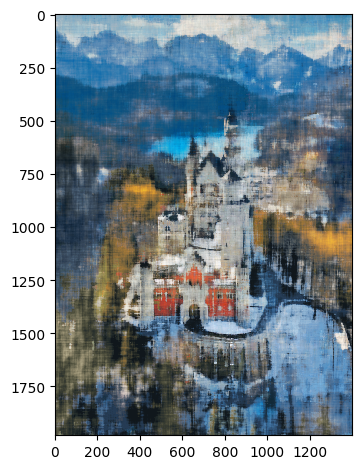

Epoch 3000: training loss 1.6335768699645996: 100%|█████████████████████████████████| 3001/3001 [02:27<00:00, 20.33it/s]


In [306]:
pbar = tqdm(range(3001))
for epoch in pbar:
    pos, rgb = dataloader.sample(batch_size)
    pred = model.forward(pos)

    loss = mse(torch.tensor(rgb, device=device).float(), pred)*100
    
    optim.zero_grad()
    loss.backward()
    optim.step()

    training_loss.append(loss.detach().cpu().numpy())

    if epoch%200 == 0:
        reconstructed = model.forward(all_coords/im.shape[:2])
        reconstructed_shell = np.zeros(im.shape)
        reconstructed_shell[all_coords[:, 0], all_coords[:, 1]] = reconstructed.cpu().detach().numpy()
        skio.imshow(reconstructed_shell)
        plt.show()
        training_imgs.append(reconstructed_shell)
    
    pbar.set_description(f"Epoch {epoch}: training loss {training_loss[-1]}")

In [6]:
def mse_to_psnr(mse):
    return 10*np.log10(1/mse)

Text(0, 0.5, 'PSNR')

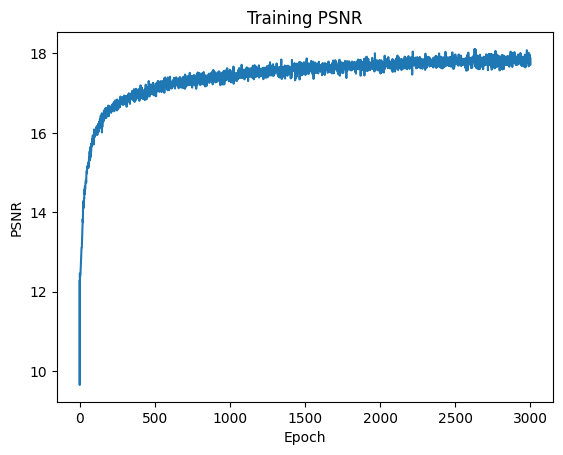

In [308]:
plt.plot(mse_to_psnr(np.array(training_loss)/100))
plt.title("Training PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR")

In [ ]:
plt.plot(mse_to_psnr(np.array(training_loss)/100))
plt.title("Training PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR")

## Part 2
NERFs!

In [7]:
data = np.load(f"imgs/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

In [8]:
K = np.array([[focal, 0, images_train.shape[1]/2], [0, focal, images_train.shape[2]/2], [0, 0, 1]])

In [9]:
K

array([[277.7777578,   0.       , 100.       ],
       [  0.       , 277.7777578, 100.       ],
       [  0.       ,   0.       ,   1.       ]])

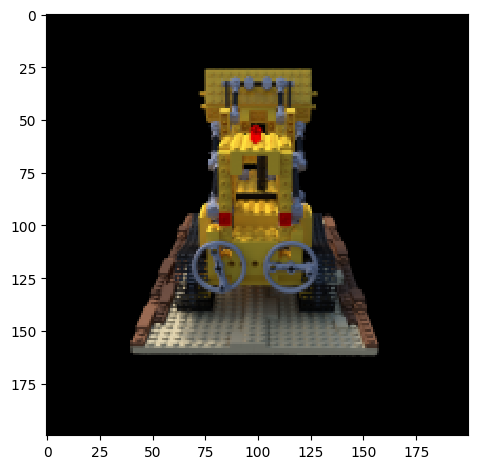

In [10]:
skio.imshow(images_train[0])

In [11]:
all_coords = np.meshgrid(np.arange(200), np.arange(200))
all_coords[0] = all_coords[0].flatten()
all_coords[1] = all_coords[1].flatten()
all_coords = np.array(all_coords).T + .5

In [12]:
def stack_ones(x):
    return np.concatenate([x, np.ones((1, x.shape[-1]))])

In [13]:
def transform(c2w, x_c):
    return (c2w @ stack_ones(x_c))[:3]

In [14]:
def pixel_to_camera(K, uv, s):
    assert uv.shape[0] == 2
    return s*(np.linalg.inv(K)@stack_ones(uv))

In [15]:
def pixel_to_ray(K, c2w, uv):
    uv = uv.astype(np.float64)
    uv += .5
    ro = c2w @ np.array([0, 0, 0, 1])
    Xc = pixel_to_camera(K, uv.T, 1)

    if len(c2w.shape) > 2:
        Xw = np.array([transform(c2w[i], Xc[:, i:i+1]) for i in range(c2w.shape[0])])[:, :3, 0]
        ro = ro[:, :3]
        rd = Xw - ro    
    else:
        Xw = transform(c2w, Xc) 
        ro = ro[:3]
        rd = Xw.T - ro
        
    return ro, rd/np.linalg.norm(rd, axis=-1)[:, np.newaxis]

In [16]:
all_coords = np.meshgrid(np.arange(200), np.arange(200))
all_coords[0] = all_coords[0].flatten()
all_coords[1] = all_coords[1].flatten()
all_coords = np.array(all_coords).T

In [17]:
class RaysData:
    def __init__(self, images, K, c2ws):
        self.images = images
        self.K = K
        self.c2ws = c2ws

    def get_rays(self, image_index):
        all_coords = np.meshgrid(np.arange(self.images.shape[1]), np.arange(self.images.shape[2]))
        all_coords[0] = all_coords[0].flatten()
        all_coords[1] = all_coords[1].flatten()
        all_coords = np.array(all_coords).T
        
        c2ws = self.c2ws[image_index]
        return *pixel_to_ray(K, c2ws, all_coords), self.images[image_index]

    def sample_rays(self, N):
        idx = np.random.randint([0, 0, 0], high=self.images.shape[:3], size=(N, 3))
        c2ws = self.c2ws[idx[:, 0]] # First index is which image
        return *pixel_to_ray(K, c2ws, idx[:, 1:]), self.images[idx[:, 0], idx[:, 2], idx[:, 1]]

In [18]:
def sample_along_rays(rays_o, rays_d, high=6.0, low = 2.0, num_samples=64, perturb=True):
    n = rays_o.shape[0]

    t_width = (high - low)/num_samples
    t = np.linspace(low, high, num_samples + 1)[:-1]
    
    if perturb:
        t = t + (np.random.rand(t.shape[0]) * t_width)
        
    t = t.reshape(1, -1, 1)
    ray_d_expanded = rays_d[:, np.newaxis, :]
    points_along_ray_d = t * ray_d_expanded

    if len(rays_o.shape) > 1:
        ray_o_expanded = rays_o[:, np.newaxis, :]
        points = ray_o_expanded + points_along_ray_d
    else:
        points = rays_o + points_along_ray_d

    return points, t

In [19]:
import viser, time  # pip install viser
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100)
points, t = sample_along_rays(rays_o, rays_d, perturb=True)
H, W = images_train.shape[1:3]
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000)

(viser) Share URL requested! (expires in 24 hours)

╭───────────────────────── viser ─────────────────────────╮
│             ╷                                           │
│   HTTP      │ http://0.0.0.0:8080                       │
│   Websocket │ ws://0.0.0.0:8080                         │
│   Share URL │ https://feature-font.share.viser.studio   │
│             ╵                                           │
╰─────────────────────────────────────────────────────────╯

(viser) Connection opened (0, 1 total), 506 persistent messages

(viser) Connection closed (0, 0 total)


KeyboardInterrupt



### 2.4 NERF Training

In [20]:
import datetime
import os

In [26]:
# Get the current time
now = datetime.datetime.now()

# Format the time
run_id = now.strftime('%Y_%m_%d-%H_%M_%S')
os.mkdir(f"runs/{run_id}")

In [27]:
os.mkdir(f"runs/{run_id}/val_imgs/")

In [21]:
run_id = "2023_11_14-12_39_18"

In [22]:
class NERF(nn.Module):
    def __init__(self, L_coord=10, L_ray=4):
        super().__init__()
        self.L_coord = L_coord
        self.L_ray = L_ray

        self.coord_inp_size = 3*(self.L_coord*2 + 1)
        self.rd_inp_size = 3*(self.L_ray*2 + 1)

        self.pos_model1 = nn.Sequential(
            nn.Linear(self.coord_inp_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.pos_model2 = nn.Sequential(
            nn.Linear(256 + self.coord_inp_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )

        self.density_model = nn.Sequential(
            nn.Linear(256, 1),
            nn.ReLU()
        )

        self.rgb_model1 = nn.Linear(256, 256)

        self.rgb_model2 = nn.Sequential(
            nn.Linear(256 + self.rd_inp_size, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid()
        )
        
    def forward(self, pos, rd):        
        encoded_pos = positional_encoding(pos, self.L_coord)
        encoded_pos = torch.tensor(encoded_pos, device=device).float()
        encoded_pos = encoded_pos.reshape(*encoded_pos.shape[:2], -1)

        encoded_ray = positional_encoding(rd, self.L_ray)
        encoded_ray = torch.tensor(encoded_ray, device=device).float()
        encoded_ray = encoded_ray.reshape(encoded_ray.shape[0], 1, -1)
        tiled_ray = torch.tile(encoded_ray, (1, pos.shape[1], 1))
        
        p1 = self.pos_model1(encoded_pos) #TODO Add residual
        z1 = torch.cat([p1, encoded_pos], axis=-1)
        p2 = self.pos_model2(z1)

        density = self.density_model(p2)

        r1 = self.rgb_model1(p2) # TODO actually add in rd
        z2 = torch.cat([r1, tiled_ray], axis=-1)
        rgb = self.rgb_model2(z2)
        
        return density, rgb

In [23]:
def get_volrend_weights(sigmas, t, device=device):
    t = torch.tensor(t, device=device)
    t = t[:, 1:, :] - t[:, :-1, :]
    t = torch.cat([t, torch.tensor([[[torch.mean(t).item()]]], device=device)], dim=1)
    # t = torch.cat([torch.tensor([[[0]]], device=device), torch.tensor(t,device=device)], dim=1)
    
    T = torch.exp(-torch.cumsum(sigmas*t, dim=1))
    T = torch.cat([torch.ones(T.shape[0], 1, T.shape[-1], device=device), T], axis=1) # Add in 1 to the start
    return T[:, :-1, :]*(1-torch.exp(-sigmas*t)), T

def volrend(sigmas, rgbs, step_size, device=device, bg_color=[0, 0, 0]):
    w, T = get_volrend_weights(sigmas, step_size, device=device)

    C_r = w*rgbs
    C_r = torch.cat([C_r, (T[:, -1:, :]*torch.tensor(bg_color, device=device))], dim=1)
    C_r = torch.sum(C_r, axis=1)
    return C_r
                         
def volrend_old(sigmas, rgbs, step_size, device=device, bg_color=[0, 0, 0]):
    T = torch.exp(-torch.cumsum(sigmas*step_size, dim=1))
    T = torch.cat([torch.ones(T.shape[0], 1, T.shape[-1], device=device), T], axis=1) # Add in 1 to the start

    C_r = T[:, :-1, :]*((1-torch.exp(-sigmas*step_size))*rgbs)
    C_r = torch.cat([C_r, (T[:, -1:, :]*torch.tensor(bg_color, device=device))], dim=1)
    C_r = torch.sum(C_r, axis=1)
    return C_r

In [24]:
def predict_image(model, dataset, index, bg_color=[0,0,0]):
    with torch.no_grad():
        rays_o, rays_d, img = dataset.get_rays(index)
        points, t = sample_along_rays(rays_o, rays_d, perturb=False)
    
        density_pred, rgb_pred = model.forward(points, rays_d)
        C_r = volrend(density_pred, rgb_pred, t, bg_color=bg_color) # volrend_old(density_pred, rgb_pred, (6.0 - 2.0) / 32)
    
        val_loss = mse(torch.tensor(img.reshape(-1, 3), device=device).float(), C_r)
        full_val_loss.append(val_loss)
        
        reconstructed_shell = np.zeros(img.shape)
        reconstructed_shell[all_coords[:, 1], all_coords[:, 0]] = C_r.cpu().detach().numpy()
        return reconstructed_shell

In [25]:
def standardize_img(img):
    return (img*255).astype(np.uint8)

In [26]:
dataset = RaysData(images_train, K, c2ws_train)
model = NERF().to(device)

In [27]:
model_checkpoint_epoch = 10000
model.load_state_dict(torch.load(f"runs/{run_id}/models/nerf_{model_checkpoint_epoch}"))

<All keys matched successfully>

In [28]:
val_dataset = RaysData(images_val, K, c2ws_val)

In [29]:
optim = torch.optim.Adam(model.parameters(), lr=5e-4)
batch_size = 10000
mse = nn.MSELoss()
training_loss = []
training_imgs = [] # Taken every 200 epochs
full_val_loss = [] # Taken every 200 epochs
high = 6.0
low = 2.0
num_samples = 64

In [30]:
rays_o, rays_d, img = dataset.get_rays(0)
points, t = sample_along_rays(rays_o, rays_d, perturb=False)

density_pred, rgb_pred = model.forward(points, rays_d)

In [31]:
w, T = get_volrend_weights(density_pred, t)

In [32]:
# w = torch.rand(10, 4, 1, device=device)
sample_pdf = w/torch.sum(w, dim=(1,2)).reshape(-1, 1, 1)
sample_pdf = torch.nan_to_num(sample_pdf, nan=0) # For all of the divided by 0s

In [33]:
sample_cdf = torch.cumsum(sample_pdf, dim=1)

In [34]:
Nf = 128

In [35]:
sample_cdf.shape

torch.Size([40000, 64, 1])

In [36]:
fine_samples = torch.sort(torch.rand(sample_cdf.shape[0], Nf, 1, device=device), dim=1).values

In [37]:
sample_cdf.shape

torch.Size([40000, 64, 1])

In [38]:
fine_samples.shape

torch.Size([40000, 128, 1])

In [39]:
bins = torch.argmax((fine_samples[:, 0, :].reshape(-1, 1, 1) < sample_cdf).double(), 1, keepdim=True)
nonzero_bin_indices = torch.argwhere(bins > 0)[:, 0]
bins = bins[nonzero_bin_indices] - 1
t_f = bins*(high - low)/num_samples + low

In [21]:
import tensorflow as tf
def sample_pdf(bins, weights, N_samples, det=False):

    # Get pdf
    weights += 1e-5  # prevent nans
    pdf = weights / tf.reduce_sum(weights, -1, keepdims=True)
    cdf = tf.cumsum(pdf, -1)
    cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], -1)

    # Take uniform samples
    if det:
        u = tf.linspace(0., 1., N_samples)
        u = tf.broadcast_to(u, list(cdf.shape[:-1]) + [N_samples])
    else:
        u = tf.random.uniform(list(cdf.shape[:-1]) + [N_samples])

    # Invert CDF
    inds = tf.searchsorted(cdf, u, side='right')
    below = tf.maximum(0, inds-1)
    above = tf.minimum(cdf.shape[-1]-1, inds)
    inds_g = tf.stack([below, above], -1)
    cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)

    denom = (cdf_g[..., 1]-cdf_g[..., 0])
    denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
    t = (u-cdf_g[..., 0])/denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1]-bins_g[..., 0])

    return samples

2023-11-15 10:16:15.903591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 10:16:15.903705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 10:16:15.963170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 10:16:16.157624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 10:16:17.694142: W tensorflow/compiler/tf2

In [28]:
N_rays = 300
N_samples = 64
N_importance = 128

near = 2.0
far = 6.0
t_vals = tf.linspace(0., 1., N_samples)
z_vals = near * (1.-t_vals) + far * (t_vals)
z_vals = tf.broadcast_to(z_vals, [N_rays, N_samples])

mids = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
upper = tf.concat([mids, z_vals[..., -1:]], -1)
lower = tf.concat([z_vals[..., :1], mids], -1)
# stratified samples in those intervals
t_rand = tf.random.uniform(z_vals.shape)
z_vals = lower + (upper - lower) * t_rand

In [29]:
z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])

In [31]:
z_vals_mid.shape

TensorShape([300, 63])

In [32]:
weights = tf.random.uniform(z_vals_mid.shape)

In [35]:
z_samples = sample_pdf(
    z_vals_mid, weights[..., 1:-1], N_importance, det=False)

In [37]:
z_samples.shape

TensorShape([300, 128])

In [104]:
bins[nonzero_bin_indices]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [82]:
(fine_samples[:, 0, :].reshape(-1, 1, 1) > sample_cdf).double()

NameError: name 'fine_samples' is not defined

In [62]:
sample_cdf.shape

torch.Size([40000, 64, 1])

In [55]:
torch.argmax((sample_cdf > 0).double(), 1, keepdim=True)[3704]

tensor([[38]], device='cuda:0')

In [59]:
torch.argmax((sample_cdf[3704] > 0).double())

tensor(38, device='cuda:0')

In [194]:
(torch.tensor([[[1], [5], [8]], [[2], [4], [6]]])/torch.tensor([1, 4]).reshape(-1, 1, 1)).shape

torch.Size([2, 3, 1])

In [193]:
torch.tensor([[[1], [5], [8]], [[2], [4], [6]]]).shape

torch.Size([2, 3, 1])

  0%|                                                                                          | 0/2001 [00:00<?, ?it/s]

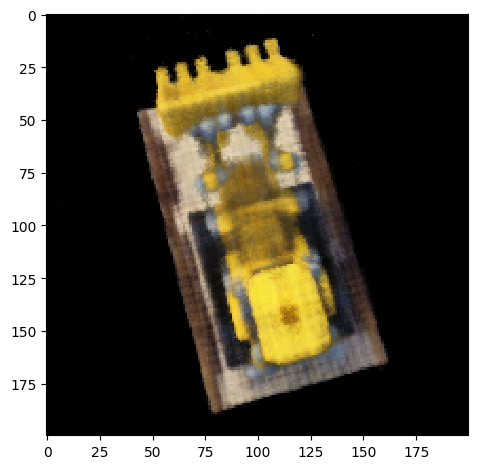

Epoch 181: training loss 0.004872755584553422:   9%|███                              | 182/2001 [04:10<35:55,  1.19s/it]

(viser) Connection opened (1, 1 total), 506 persistent messages

Epoch 195: training loss 0.004591296131488838:  10%|███▏                             | 196/2001 [04:27<35:35,  1.18s/it]

(viser) Connection closed (1, 0 total)

Epoch 199: training loss 0.0044739514140152885:  10%|███▏                            | 200/2001 [04:32<35:30,  1.18s/it]

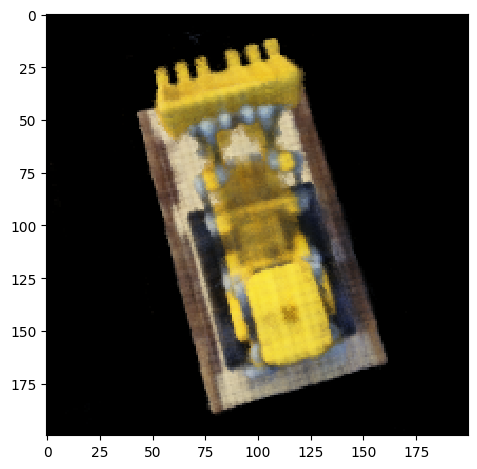

Epoch 323: training loss 0.004640322220040887:  16%|█████▎                           | 324/2001 [07:34<33:03,  1.18s/it]

(viser) Connection opened (1, 1 total), 506 persistent messages

Epoch 356: training loss 0.004067159323798716:  18%|█████▉                           | 357/2001 [08:12<32:29,  1.19s/it]

(viser) Connection closed (1, 0 total)

Epoch 357: training loss 0.004270149659021988:  18%|█████▉                           | 358/2001 [08:14<32:31,  1.19s/it]

(viser) Connection opened (1, 1 total), 506 persistent messages

Epoch 364: training loss 0.004392030654763517:  18%|██████                           | 365/2001 [08:22<32:39,  1.20s/it]

(viser) Connection closed (1, 0 total)

Epoch 399: training loss 0.0036822646483679476:  20%|██████▍                         | 400/2001 [09:04<32:23,  1.21s/it]

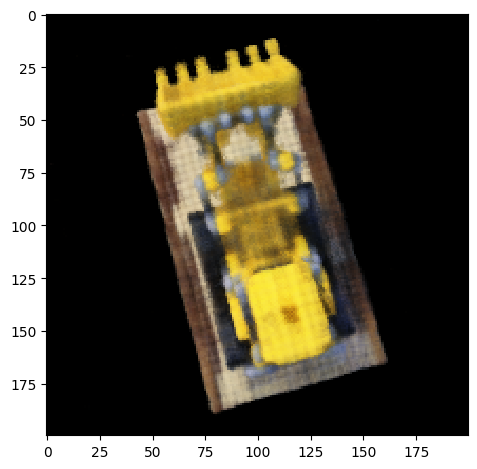

Epoch 599: training loss 0.003961534569344122:  30%|█████████▉                       | 600/2001 [13:43<33:21,  1.43s/it]

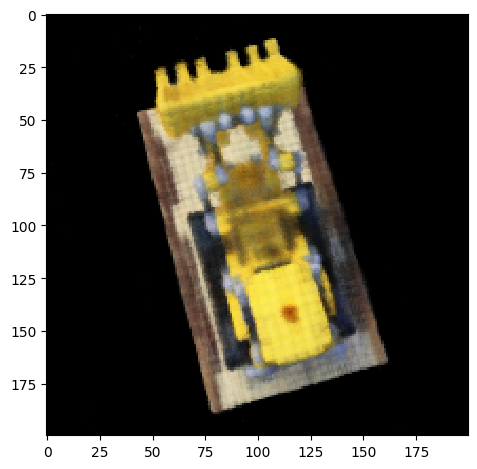

Epoch 799: training loss 0.003954858527926791:  40%|█████████████▏                   | 800/2001 [18:27<23:34,  1.18s/it]

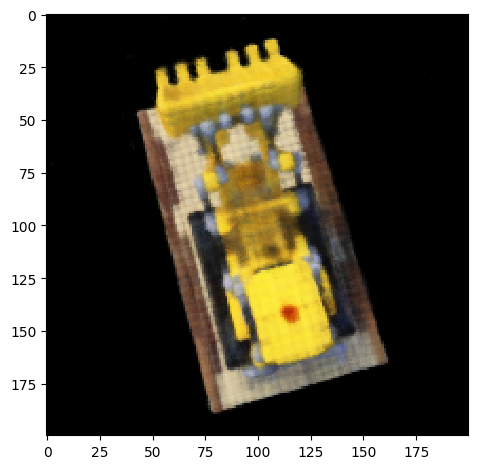

Epoch 999: training loss 0.0036011642239230954:  50%|███████████████▍               | 1000/2001 [23:00<19:57,  1.20s/it]

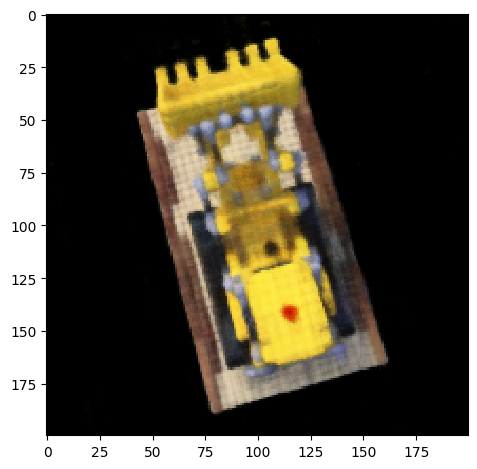

Epoch 1199: training loss 0.0035226340320052463:  60%|█████████████████▉            | 1200/2001 [27:34<16:09,  1.21s/it]

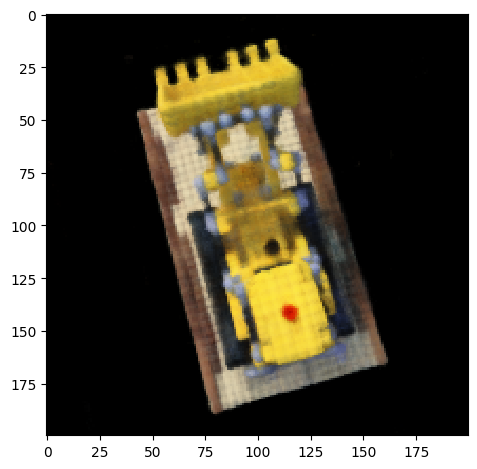

Epoch 1399: training loss 0.0033423920300314934:  70%|████████████████████▉         | 1400/2001 [32:08<12:04,  1.21s/it]

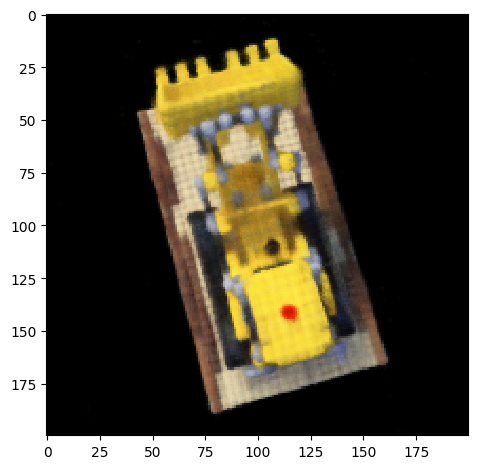

Epoch 1599: training loss 0.003170753169145911:  80%|████████████████████████▊      | 1600/2001 [36:40<07:58,  1.19s/it]

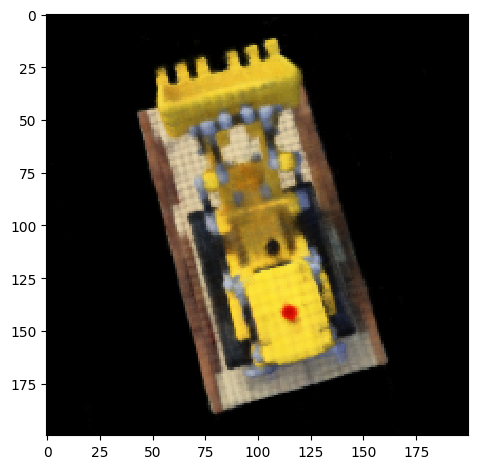

Epoch 1799: training loss 0.003287549634545727:  90%|███████████████████████████▉   | 1800/2001 [41:24<03:57,  1.18s/it]

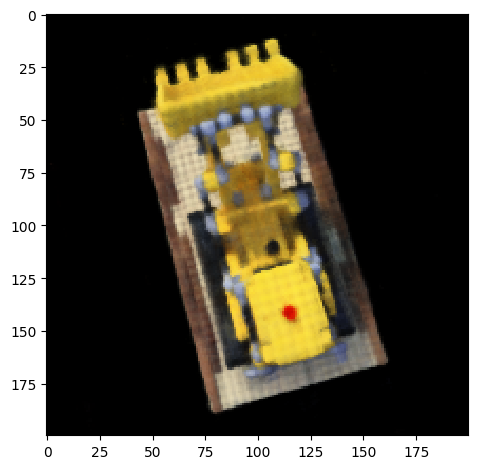

Epoch 1999: training loss 0.0038057545868582254: 100%|█████████████████████████████▉| 2000/2001 [46:11<00:01,  1.19s/it]

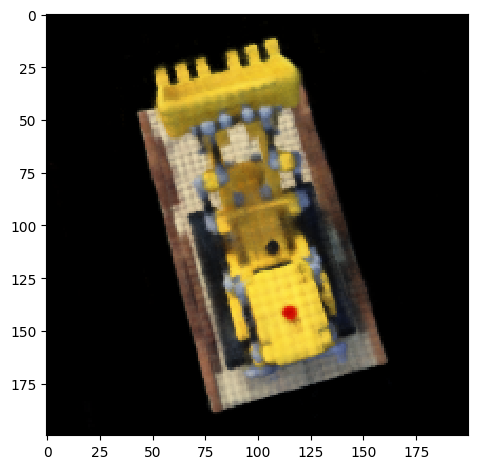

Epoch 2000: training loss 0.00352530441201487: 100%|████████████████████████████████| 2001/2001 [46:47<00:00,  1.40s/it]


In [133]:
pbar = tqdm(range(2001))
for epoch in pbar:
    rays_o, rays_d, pixels = dataset.sample_rays(batch_size)
    points, t = sample_along_rays(rays_o, rays_d, high=high, low=low, num_samples=num_samples, perturb=True)

    # t = torch.tile(torch.tensor([[[(high - low)/num_samples]]], device=device, dtype=torch.float64), (1, 64, 1))
    # t = torch.cumsum(t, dim=1) + 2
    
    density_pred, rgb_pred = model.forward(points, rays_d)
    C_r = volrend(density_pred, rgb_pred, t)

    loss = mse(torch.tensor(pixels, device=device, dtype=torch.float64), C_r)
    
    optim.zero_grad()
    loss.backward()
    optim.step()

    training_loss.append(loss.detach().cpu().numpy())

    if epoch%200 == 0:
        val_loss = 0
        for i in range(images_val.shape[0]):
            val_img = images_val[i]
            val_img_pred = predict_image(model, val_dataset, i) 

            val_loss += mse(torch.tensor(val_img_pred), torch.tensor(val_img))
            if i==0:
                skio.imshow(val_img_pred)
                plt.show()
                training_imgs.append(val_img_pred)
                skio.imsave(f"runs/{run_id}/val_imgs/{epoch}.jpg", standardize_img(val_img_pred))
                
        full_val_loss.append(val_loss/images_val.shape[0])
        
    pbar.set_description(f"Epoch {epoch}: training loss {training_loss[-1]}")

In [ ]:
torch.save(model.state_dict(), f"runs/{run_id}/models/nerf_{epoch}")

In [134]:
save_data = {"training_loss": training_loss, "full_val_loss": full_val_loss}
np.save(f"runs/{run_id}/data.npy", save_data)

In [31]:
test_dataset = RaysData(np.zeros((c2ws_test.shape[0], 200, 200, 3)), K, c2ws_test)

In [ ]:
frames = []
with torch.no_grad():
    for i in range(60):
        img_pred = predict_image(model, test_dataset, i)
        frames.append(img_pred)

In [ ]:
standardized_frames = [standardize_img(frame) for frame in frames]

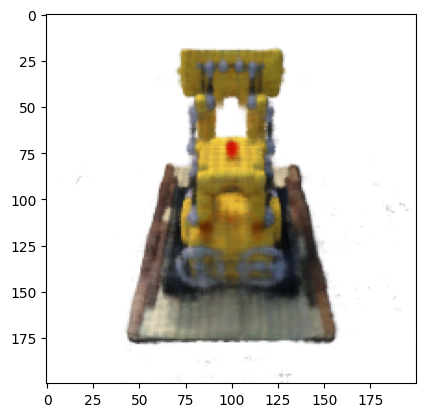

In [86]:
test_img = predict_image(model, test_dataset, 0, bg_color=[1, 1, 1])
plt.imshow(test_img)

In [67]:
index = 1
with torch.no_grad():
    rays_o, rays_d, img = dataset.get_rays(index)
    points, t = sample_along_rays(rays_o, rays_d, perturb=False)

    density_pred, rgb_pred = model.forward(points, rays_d)

In [77]:
def density_rend(sigmas, step_size, device=device, bg_color=[0, 0, 0]):
    w, T = get_volrend_weights(sigmas, step_size, device=device)

    step_size = (step_size - step_size.min())/(step_size.max() - step_size.min())
    C_r = w*(torch.tensor(step_size, device=device)) # torch.tensor([1, 1, 1], device=device)
    C_r =  torch.tile(C_r, (1, 1, 3))
    C_r = torch.cat([C_r, (T[:, -1:, :]*torch.tensor(bg_color, device=device))], dim=1)
    C_r = torch.sum(C_r, axis=1)
    return C_r

def predict_density_image(model, dataset, index, bg_color=[0,0,0]):
    with torch.no_grad():
        rays_o, rays_d, img = dataset.get_rays(index)
        points, t = sample_along_rays(rays_o, rays_d, perturb=False)
    
        density_pred, rgb_pred = model.forward(points, rays_d)

        C_r = density_rend(density_pred, t, bg_color=[0, 0, 0])
        C_r = (C_r - C_r.min())/(C_r.max() - C_r.min())
        
        val_loss = mse(torch.tensor(img.reshape(-1, 3), device=device).float(), C_r)
        full_val_loss.append(val_loss)
        
        reconstructed_shell = np.zeros(img.shape)
        reconstructed_shell[all_coords[:, 1], all_coords[:, 0]] = C_r.cpu().detach().numpy()

        return reconstructed_shell

In [88]:
def make_gif(fname="movie.gif", bg_color=[0, 0, 0], density=False):
    frames = []
    with torch.no_grad():
        for i in range(60):
            if not density:
                img_pred = predict_image(model, test_dataset, i, bg_color=bg_color)
            else:                
                img_pred = predict_density_image(model, test_dataset, i, bg_color=bg_color)
            
            frames.append(img_pred)

    standardized_frames = [standardize_img(frame) for frame in frames]

    import imageio
    imageio.mimsave(f'runs/{run_id}/{fname}', standardized_frames)

make_gif("movie_yellow_3000.gif", density=False, bg_color=[1, 1, 0])

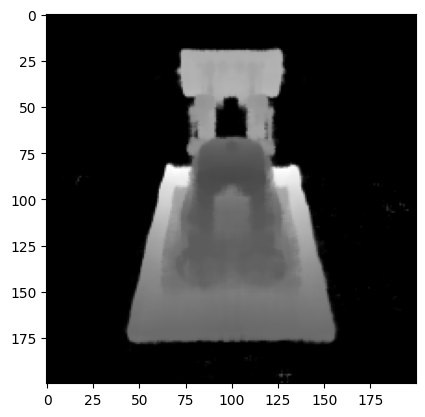

In [78]:
density_image = predict_density_image(model, test_dataset, 0)
plt.imshow(density_image)

In [72]:
def density_rend(sigmas, step_size, device=device, bg_color=[0, 0, 0]):
    w, T = get_volrend_weights(sigmas, step_size, device=device)

    step_size = (step_size - step_size.min())/(step_size.max() - step_size.min())
    C_r = w*(torch.tensor(step_size, device=device)) # torch.tensor([1, 1, 1], device=device)
    C_r =  torch.tile(C_r, (1, 1, 3))
    C_r = torch.cat([C_r, (T[:, -1:, :]*torch.tensor(bg_color, device=device))], dim=1)
    C_r = torch.sum(C_r, axis=1)
    return C_r

    
C_r = density_rend(density_pred, t, bg_color=[0, 0, 0])
C_r = (C_r - C_r.min())/(C_r.max() - C_r.min())

val_loss = mse(torch.tensor(img.reshape(-1, 3), device=device).float(), C_r)
full_val_loss.append(val_loss)

reconstructed_shell = np.zeros(img.shape)
reconstructed_shell[all_coords[:, 1], all_coords[:, 0]] = C_r.cpu().detach().numpy()

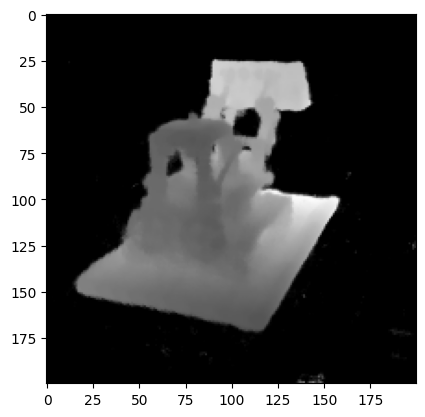

In [74]:
plt.imshow(standardize_img(reconstructed_shell))

In [2]:
def density_rend(sigmas, step_size, device=device, bg_color=[0, 0, 0]):
    T = torch.exp(-torch.cumsum(sigmas*step_size, dim=1))
    T = torch.cat([torch.ones(T.shape[0], 1, T.shape[-1], device=device), T], axis=1) # Add in 1 to the start

    C_r = T[:, :-1, :]*((1-torch.exp(-sigmas*step_size))*((1-torch.exp(-sigmas*step_size))*torch.tensor([1, 1, 1], device=device)))
    C_r = torch.cat([C_r, (T[:, -1:, :]*torch.tensor(bg_color, device=device))], dim=1)
    C_r = torch.sum(C_r, axis=1)
    return C_r

C_r = density_rend(density_pred, (6.0 - 2.0) / 32, bg_color=[1, 1, 1])

val_loss = mse(torch.tensor(img.reshape(-1, 3), device=device).float(), C_r)
full_val_loss.append(val_loss)

reconstructed_shell = np.zeros(img.shape)
reconstructed_shell[all_coords[:, 1], all_coords[:, 0]] = C_r.cpu().detach().numpy()

NameError: name 'device' is not defined

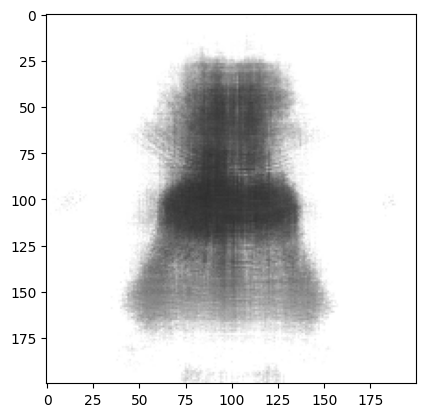

In [164]:
plt.imshow(reconstructed_shell)

In [188]:
import imageio
imageio.mimsave(f'runs/{run_id}/movie.gif', standardized_frames)

In [92]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_positional_encodings(self):
        x = np.random.uniform(size=(200, 100, 3))
        self.assertTrue((positional_encoding(x, L=0).reshape(x.shape) == x).all())
        
        pe = positional_encoding(x, L=10)
        self.assertTrue(pe.shape[:-1] == x.shape)
        self.assertTrue(pe.shape[-1] == 10*2 + 1)

        for i in range(0, 10):
            self.assertTrue((pe[:, :, :, 2*i+1] == np.sin((2**i)*np.pi*pe[:,:,:,0])).all())
            self.assertTrue((pe[:, :, :, 2*i+2] == np.cos((2**i)*np.pi*pe[:,:,:,0])).all())
        
    
    def test_stack_ones(self):
        x = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
        y = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [1, 1, 1, 1]])
        
        self.assertTrue((y == stack_ones(x)).all(), 'Stack ones fails.')

    def test_transform(self):
        for _ in range(100):
            x = np.random.randint(0, 1000, size=(3, 5))
            R = np.random.randn(3, 3)
            t = np.random.randn(3, 1)
            c2w = np.vstack([np.hstack([R, t]), [0, 0, 0, 1]])
            reconstructed = transform(np.linalg.inv(c2w), transform(c2w, x))
            self.assertTrue(((reconstructed - 1e-8 <= x)&(x<=reconstructed + 1e8)).all(), 'transform() fails')

    def test_pixel_to_camera(self):
        for _ in range(100):
            fx = np.random.randint(100, 300)
            fy = np.random.randint(100, 300)
            ox = np.random.randint(100, 1000)
            oy = np.random.randint(100, 1000)
    
            test_K = np.array([[fx, 0, ox], [0, fy, oy], [0, 0, 1]])            
            Xc = np.random.randint(-1000, 1000, size=(3, 5))
            uvs = test_K@Xc
            s = uvs[2]
            uv = uvs[:2]/s
    
            reconstructed = pixel_to_camera(test_K, uv, s)
            self.assertTrue(((reconstructed - 1e-8<=Xc)&(Xc<=reconstructed + 1e8)).all(), 'pixel_to_camera() fails')

    def test_volrend(self):
        torch.manual_seed(42)
        sigmas = torch.rand((10, 64, 1))
        rgbs = torch.rand((10, 64, 3))
        step_size = (6.0 - 2.0) / 64
        rendered_colors = volrend(sigmas, rgbs, step_size, device=torch.device('cpu'))
        
        correct = torch.tensor([
            [0.5006, 0.3728, 0.4728],
            [0.4322, 0.3559, 0.4134],
            [0.4027, 0.4394, 0.4610],
            [0.4514, 0.3829, 0.4196],
            [0.4002, 0.4599, 0.4103],
            [0.4471, 0.4044, 0.4069],
            [0.4285, 0.4072, 0.3777],
            [0.4152, 0.4190, 0.4361],
            [0.4051, 0.3651, 0.3969],
            [0.3253, 0.3587, 0.4215]
          ])
        
        self.assertTrue(torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4))

unittest.main(argv=[''], verbosity=2, exit=False)

test_pixel_to_camera (__main__.TestNotebook) ... ok
test_positional_encodings (__main__.TestNotebook) ... ok
test_stack_ones (__main__.TestNotebook) ... ok
test_transform (__main__.TestNotebook) ... ok
test_volrend (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.082s

OK
